<a href="https://colab.research.google.com/github/km-0-8/iowa_liqueur/blob/main/liqueur_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# リキュール販売データを用いた需要予測モデルの構築
米国アイオワ州のリキュール販売記録をもとに、販売量や売上金額の予測を行う回帰モデルを構築。解釈性の高いモデル構築のプロセスを目指した。

##### 基本情報

[https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy/about_data](https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy/about_data)

| 英語カラム名              | 日本語説明                                      |
|---------------------------|-----------------------------------------------|
| invoice_and_item_number   | 伝票／行番号（Invoice/Item）                    |
| date                      | 注文日（日付）                                 |
| store_number              | 店舗番号                                       |
| store_name                | 店舗名                                         |
| address                   | 住所                                           |
| city                      | 市区町村名                                     |
| zip_code                  | 郵便番号                                       |
| store_location            | 店舗の位置（緯度・経度）                        |
| county_number             | 郡番号（County Number）                        |
| county                    | 郡名                                           |
| category                  | 酒類カテゴリコード                             |
| category_name             | 酒類カテゴリ名                                 |
| vendor_number             | ベンダー番号（Vendor Number）                 |
| vendor_name               | ベンダー名（Vendor）                          |
| item_number               | 商品番号（Item Number）                        |
| item_description          | 商品説明（Item Description）                   |
| pack                      | ケース内のボトル数（Pack）                    |
| bottle_volume_ml         | ボトル容量（ミリリットル）                     |
| state_bottle_cost         | 州が仕入れた価格（State Bottle Cost）         |
| state_bottle_retail       | 州の小売価格（State Bottle Retail）           |
| bottles_sold              | 販売本数（Bottle Quantity）                   |
| sale_dollars              | 売上額（Sale Dollars = ボトル×価格）         |
| volume_sold_liters        | 販売量（リットル）                            |
| volume_sold_gallons       | 販売量（ガロン）                              |

##### ライブラリインポート/アカウント認証


In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
!python3 --version
!pip install --no-cache-dir
!pip uninstall -y dask distributed cloudpickle pandas fsspec toolz partd dask-ml
!pip install --no-cache-dir \
  numpy==1.26.4 \
  "dask[complete]==2024.5.0" \
  dask-ml==2023.3.24 \
  cloudpickle==3.0.0 \
  pandas==2.2.2 \
  fsspec==2024.3.1 \
  toolz==0.12.1 \
  google-cloud-bigquery \
  pyarrow \
  gcsfs
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
calendar = USFederalHolidayCalendar()
from google.cloud import bigquery
import dask
import dask.dataframe as dd

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from scipy.stats import skew,pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

Python 3.11.13
ERROR: You must give at least one requirement to install (see "pip help install")
Found existing installation: dask 2024.5.0
Uninstalling dask-2024.5.0:
  Successfully uninstalled dask-2024.5.0
Found existing installation: distributed 2024.5.0
Uninstalling distributed-2024.5.0:
  Successfully uninstalled distributed-2024.5.0
Found existing installation: cloudpickle 3.0.0
Uninstalling cloudpickle-3.0.0:
  Successfully uninstalled cloudpickle-3.0.0
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: fsspec 2024.3.1
Uninstalling fsspec-2024.3.1:
  Successfully uninstalled fsspec-2024.3.1
Found existing installation: toolz 0.12.1
Uninstalling toolz-0.12.1:
  Successfully uninstalled toolz-0.12.1
Found existing installation: partd 1.4.2
Uninstalling partd-1.4.2:
  Successfully uninstalled partd-1.4.2
Found existing installation: dask-ml 2023.3.24
Uninstalling dask-ml-2023.3.24:
  Successfull

##### 🆗BQ読読み込み→ステージングテーブル生成

In [ ]:
project_id = "nodal-element-464703-v7"
client = bigquery.Client(project=project_id)
query = """
SELECT
*
FROM `bigquery-public-data.iowa_liquor_sales.sales`
"""
query_job = client.query(query)
query_job.result()
destination_table = query_job.destination

destination_uri = "gs://iowa_liquor_sales_ml/stage_data/*.parquet"
extract_job = client.extract_table(
    destination_table,
    destination_uri,
    location="US",
    job_config=bigquery.ExtractJobConfig(
        destination_format=bigquery.DestinationFormat.PARQUET
    )
)
extract_job.result()

##### 🆗カラム処理→中間テーブル生成

In [ ]:
gcs_path = "gs://iowa_liquor_sales_ml/stage_data/*.parquet"
stage_df = dd.read_parquet(
    gcs_path,
    storage_options={"token": "cloud"},
    engine="pyarrow"
)

In [ ]:
stage_df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,S19297600099,2014-06-02,4969,LAKE LIQUORS WINE AND SPIRITS,910 N 8TH ST W,CLEAR LAKE,50428,b'\x01\x01\x00\x00\x00?;\xe0\xbabYW\xc0\xdb\xd...,17,CERRO GORDO,...,52598,E & J VS,6,1750,11.83,17.75,3,53.25,5.25,1.39
1,S07871900012,2012-09-24,4376,KUM & GO #6 / MASON CITY,1920 S FEDERAL AVE,MASON CITY,50401,"b'\x01\x01\x00\x00\x00\x0b\t\x18]\xdeLW\xc0""\x...",17,CERRO GORDO,...,43334,CAPTAIN MORGAN SPICED RUM,24,375,4.50,6.74,7,47.18,2.62,0.69
2,S27530800017,2015-08-26,4232,"ELLIOTT'S GENERAL STORE,",23828 HWY J18,MORAVIA,52571,b'\x01\x01\x00\x00\x00EF\x07$a5W\xc0}\xb2b\xb8...,4,APPANOOSE,...,33717,PARAMOUNT SLOE GIN,12,1000,5.42,8.13,5,40.65,5.00,1.32
3,INV-58205200024,2023-05-05,5740,NEW STAR / KNOXVILLE,901 WEST PLEASANT ST,KNOXVILLE,50138,b'\x01\x01\x00\x00\x00\x84m\xd2\x07\xe7FW\xc0\...,<NA>,MARION,...,64870,FIREBALL CINNAMON WHISKEY,48,100,1.00,1.50,192,288.00,19.20,5.07
4,INV-00149500106,2016-09-06,2649,HY-VEE #3 / DUBUQUE,400 LOCUST ST,DUBUQUE,52001,b'\x01\x01\x00\x00\x00ux\x08\xe3\xa7\xaaV\xc0\...,31,DUBUQUE,...,37937,SKOL VODKA,12,1000,4.42,6.63,4,26.52,4.00,1.06


✅insight：この時点で以下カラムは不要と判断できる。
- invoice_and_item_number	：ユニークな値のため粒度が高すぎて意味を持たない。
- volume_sold_gallons：他の特徴量から導出される冗長な情報（目的は解釈性の高いモデルの作成であるため）

In [ ]:
df_dropped=stage_df.drop(columns=['invoice_and_item_number','volume_sold_gallons','store_location'])
df_dropped.to_parquet("gs://iowa_liquor_sales_ml/cleaned_data/first_cleaned", write_index=False)

##### 🆗欠損値処理→中間テーブル生成

In [ ]:
gcs_path = "gs://iowa_liquor_sales_ml/cleaned_data/first_cleaned/*.parquet"
first_cleaned_df = dd.read_parquet(
    gcs_path,
    storage_options={"token": "cloud"},
    engine="pyarrow"
)

###### 位置情報のnull処理

In [ ]:
first_cleaned_df.isnull().sum().compute()

,0
date,0
store_number,0
store_name,0
address,83896
city,83895
zip_code,83962
county_number,7628875
county,160698
category,16974
category_name,25040


In [ ]:
cols = ["address", "city", "zip_code", "county_number", "county"]
null_rows = first_cleaned_df[cols].isnull().all(axis=1)
null_count = first_cleaned_df[null_rows].shape[0].compute()
print(f"店舗の位置情報がすべて null のレコード数: {null_count}")

店舗の位置情報がすべて null のレコード数: 83895


✅insight：位置情報が完全に把握できないレコードは位置の特定ができず推測補完ができない。かつ、8万/3000万レコードと全体の0.3%程度であるためそのまま削除する。

In [ ]:
df_geo_null_cleaned = first_cleaned_df[~null_rows]
df_geo_null_cleaned.isnull().sum().compute()

,0
date,0
store_number,0
store_name,0
address,1
city,0
zip_code,67
county_number,7544980
county,76803
category,16748
category_name,24814


✅insight：addressはほぼ欠損無しで、安定しているため同一のaddressからcountryを補完

In [ ]:
address_to_county = (
    df_geo_null_cleaned[~df_geo_null_cleaned["county"].isnull()][["address", "county"]]
    .drop_duplicates()
    .compute()
)
address_to_county = address_to_county.dropna()
df_geo_null_cleaned = df_geo_null_cleaned.merge(address_to_county, on="address", how="left", suffixes=("", "_from_address"))
df_geo_null_cleaned["county"] = df_geo_null_cleaned["county"].fillna(df_geo_null_cleaned["county_from_address"])
df_geo_null_cleaned = df_geo_null_cleaned.drop(columns=["county_from_address"])
df_geo_null_cleaned.isnull().sum().compute()

,0
date,0
store_number,0
store_name,0
address,1
city,0
zip_code,67
county_number,7627582
county,5036
category,17028
category_name,25212


✅insight：contryの残りnull数は5千/3000万レコードと全体の0.02%程度であるためそのまま削除する。

In [ ]:
cols = ["address", "zip_code", "county"]
df_geo_null_cleaned = df_geo_null_cleaned[~df_geo_null_cleaned[cols].isnull().any(axis=1)]

In [ ]:
df_null_cleaned =df_geo_null_cleaned

###### リキュール情報のnull処理

In [ ]:
df_liq_null_cleaned=df_null_cleaned

In [ ]:
df_liq_null_cleaned.isnull().sum().compute()

,0
date,0
store_number,0
store_name,0
address,0
city,0
zip_code,0
county_number,7622524
county,0
category,17028
category_name,25204


In [ ]:
null_count = df_liq_null_cleaned[(df_liq_null_cleaned["category"].isnull()) & (df_liq_null_cleaned["category_name"].isnull())].shape[0].compute()
print(f"category と category_name がともに null のレコード数: {null_count}")

category と category_name がともに null のレコード数: 17028


✅insight：category_nameからcategoryを補完できないと判断したため、categoryのnullを削除する（全体に対して0.05%程度）

In [ ]:
df_liq_null_cleaned = df_liq_null_cleaned[~df_liq_null_cleaned["category"].isnull()]

✅insight：nullが少数のカラムの欠損レコードをすべて足しても全体のレコード数に対して0.08%しか影響がないためそのまま削除する

In [ ]:
cols = ["vendor_number", "vendor_name", "state_bottle_cost", "state_bottle_retail","sale_dollars"]
df_liq_null_cleaned = df_liq_null_cleaned[~df_liq_null_cleaned[cols].isnull().any(axis=1)]

In [ ]:
df_liq_null_cleaned.isnull().sum().compute()

,0
date,0
store_number,0
store_name,0
address,0
city,0
zip_code,0
county_number,7622524
county,0
category,0
category_name,8176


✅insight：county_numberやcategory_nameは対となるカラムとの信頼性確認に使用するため残す

In [ ]:
df_null_cleaned =df_liq_null_cleaned

In [ ]:
df_null_cleaned.to_parquet("gs://iowa_liquor_sales_ml/cleaned_data/null_cleaned", write_index=False)

##### 🆗重複確認

In [ ]:
print(f"単純なレコード数確認レコード数（重複削除前）: {df.shape[0].compute()}")
df_del_dup = df.drop_duplicates()
print(f"レコード数（重複削除後）: {df.shape[0].compute()}")

✅insight：重複無し


##### 🆗冗長カラム処理→中間テーブル生成

In [ ]:
gcs_path = "gs://iowa_liquor_sales_ml/cleaned_data/null_cleaned/*.parquet"
null_cleaned_df = dd.read_parquet(
    gcs_path,
    storage_options={"token": "cloud"},
    engine="pyarrow"
)

In [ ]:
conflicts = (
    null_cleaned_df.groupby("store_number")["store_name"]
    .nunique()
    .reset_index()
    .rename(columns={"store_name": "distinct_store_names"})
)

conflicts_filtered = conflicts[conflicts["distinct_store_names"] > 1]
conflict_store_numbers = conflicts_filtered["store_number"].compute()
conflict_store_names = null_cleaned_df[null_cleaned_df["store_number"].isin(conflict_store_numbers)][["store_number", "store_name"]]
conflict_store_names = conflict_store_names.drop_duplicates().compute()
conflict_store_names.sort_values("store_number")

,store_number,store_name
5221,10023,HY-VEE FAST AND FRESH #3 (7592) / WEST DES MOINES
11017,10023,HY-VEE FAST AND FRESH #3 / WEST DES MOINES
129825,10024,HY-VEE FAST AND FRESH #2 / WEST DES MOINES
10705,10024,HY-VEE FAST AND FRESH #2 (7591) / WEST DES MOINES
30551,10025,HY-VEE FAST AND FRESH #4 (7583) / URBANDALE
...,...,...
76060,9051,WILDCAT DISTILLING / DUNCOMBE
156832,9052,173 CRAFT DISTILLERY (ET)
83122,9052,173 CRAFT DISTILLERY
14319,9911,NORTH AMERICAN SPIRITS


✅insight：store_numberに対してstore_nameに表記ゆれが発生している  
→	store_numberに対して同一の内容であると考え、store_numberの情報は信頼。  
よって、冗長なstore_nameは削除しstore_numberのみ残す

In [ ]:
conflicts_county = (
    null_cleaned_df.groupby("county_number")["county"]
    .nunique()
    .reset_index()
    .rename(columns={"county": "distinct_county"})
)
conflicts_filtered_county = conflicts_county[conflicts_county["distinct_county"] > 1]
conflict_county_numbers = conflicts_filtered_county["county_number"].compute()
conflict_countys = null_cleaned_df[null_cleaned_df["county_number"].isin(conflict_county_numbers)][["county_number", "county"]]
conflict_countys = conflict_countys.drop_duplicates().compute()
conflict_countys.sort_values("county_number")

,county_number,county


✅insight：county_numberに対してcountryは1:1。よって、冗長なcountryは削除しcounty_numberのみ残す

In [ ]:
conflicts_category = (
    null_cleaned_df.groupby("category")["category_name"]
    .nunique()
    .reset_index()
    .rename(columns={"category_name": "distinct_category_name"})
)
conflicts_filtered_category = conflicts_category[conflicts_category["distinct_category_name"] > 1]
conflict_category_numbers = conflicts_filtered_category["category"].compute()
conflict_category = null_cleaned_df[null_cleaned_df["category"].isin(conflict_category_numbers)][["category", "category_name"]]
conflict_category = conflict_category.drop_duplicates().compute()
conflict_category.sort_values("category")

,category,category_name
124437,1011300,TENNESSEE WHISKIES
14248,1011300,SINGLE BARREL BOURBON WHISKIES
4244,1011300.0,SINGLE BARREL BOURBON WHISKIES
15,1011300.0,TENNESSEE WHISKIES
17052,1011400.0,BOTTLED IN BOND BOURBON
...,...,...
34,1081500.0,TRIPLE SEC
137,1701100,TEMPORARY & SPECIALTY PACKAGES
82286,1701100,DECANTERS & SPECIALTY PACKAGES
21,1701100.0,TEMPORARY & SPECIALTY PACKAGES


✅insight：categoryに対してcategory_nameに表記ゆれが発生している  
→	categoryに対して同一の内容であると考え、categoryの情報は信頼。  
よって、冗長なcategory_nameは削除しcategoryのみ残す

In [ ]:
conflicts_vendor = (
    null_cleaned_df.groupby("vendor_number")["vendor_name"]
    .nunique()
    .reset_index()
    .rename(columns={"vendor_name": "distinct_vendor_name"})
)
conflicts_filtered_vendor = conflicts_vendor[conflicts_vendor["distinct_vendor_name"] > 1]
conflict_vendor_numbers = conflicts_filtered_vendor["vendor_number"].compute()
conflict_vendor = null_cleaned_df[null_cleaned_df["vendor_number"].isin(conflict_vendor_numbers)][["vendor_number", "vendor_name"]]
conflict_vendor = conflict_vendor.drop_duplicates().compute()
conflict_vendor.sort_values("vendor_number")

,vendor_number,vendor_name
123750,10,A HARDY USA LTD
43037,10,"A HARDY / U.S.A., LTD."
122855,10.0,"A HARDY / U.S.A., LTD."
26576,10.0,A HARDY USA LTD
24809,107,BLAUM BROS. DISTILLING CO.
...,...,...
98260,977,"WERNER DISTILLING, LLC"
29090,978,"W. J. DEUTSCH AND SONS, LTD."
14902,978,W J DEUTSCH & SONS LTD
14935,978.0,W J DEUTSCH & SONS LTD


✅insight：vendor_numberに対してvendor_nameに表記ゆれが発生している  
→	vendor_numberに対して同一の内容であると考え、vendor_numberの情報は信頼。  
よって、冗長なvendor_nameは削除しvendor_numberのみ残す

In [ ]:
conflicts_item = (
    null_cleaned_df.groupby("item_number")["item_description"]
    .nunique()
    .reset_index()
    .rename(columns={"item_description": "distinct_item_description"})
)
conflicts_filtered_item = conflicts_item[conflicts_item["distinct_item_description"] > 1]
conflict_item_numbers = conflicts_filtered_item["item_number"].compute()
conflict_item = null_cleaned_df[null_cleaned_df["item_number"].isin(conflict_item_numbers)][["item_number", "item_description"]]
conflict_item = conflict_item.drop_duplicates().compute()
conflict_item.sort_values("item_number")

,item_number,item_description
7798,100015,FIREBALL BAG IN BOX
6620,100015,FIREBALL CINNAMON WHISKEY BAG IN BOX
37959,100015,FIREBALL CINNAMON WHISKEY BAG IN BOX 1
16864,100040,GRAND MARNIER W/2 SHOT GLASSES
95687,100040,GRAND MARNIER CORDON ROUGE W/2 SHOT GLASSES
...,...,...
42847,997975,WHISTLER CALVADOS CASK FINISH IRISH WHISKEY
119333,999440,TEMPUS FUGIT CR�ME CACAO VAN
120748,999440,TF CR�ME CACAO VAN
40141,999993,KINGS COUNTY DISTILLERY WHEAT WHISKEY DISCO


✅insight：item_number	に対してitem_descriptionに表記ゆれが発生している  
→	item_number	に対して同一の内容であると考え、item_number	の情報は信頼。  
よって、冗長なitem_descriptionは削除しitem_number	のみ残す

In [ ]:
df_redundant_del = null_cleaned_df.drop(columns=['store_name',"address","city","zip_code", 'county_number',"category_name","vendor_name","item_description"])
df_redundant_del.to_parquet("gs://iowa_liquor_sales_ml/cleaned_data/redundant_del", write_index=False)

##### データ型の変換/外れ値除去/特徴量エンジニアリング

###### データ型変換

In [35]:
gcs_path = "gs://iowa_liquor_sales_ml/cleaned_data/redundant_del/*.parquet"
df_redundant_del = dd.read_parquet(
    gcs_path,
    storage_options={"token": "cloud"},
    engine="pyarrow"
)

In [36]:
df_redundant_del["vendor_number"] = df_redundant_del["vendor_number"].map_partitions(
    lambda part: part.astype(float).astype(int).astype(str),
    meta=("vendor_number", str)
)

df_redundant_del["category"] = df_redundant_del["category"].map_partitions(
    lambda part: part.astype(float).astype(int).astype(str),
    meta=("category", str)
)

###### 外れ値除去(理論的な破綻)

In [37]:
numeric_df = df_redundant_del.select_dtypes(include=["number"])
numeric_df.describe().compute().applymap(lambda x: f"{x:,.2f}" if isinstance(x, (int, float)) else x)

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters
count,"31,986,864.00","31,986,864.00","31,986,864.00","31,986,864.00","31,986,864.00","31,986,864.00","31,986,864.00"
mean,12.08,870.45,10.97,16.47,10.95,147.91,9.15
std,7.81,617.09,13.60,20.39,30.80,520.79,36.47
min,1.00,0.00,0.00,0.00,-768.00,"-9,720.00","-1,344.00"
25%,6.00,750.00,5.78,8.67,3.00,37.14,1.50
50%,12.00,750.00,8.66,13.01,6.00,78.66,4.80
75%,12.00,"1,000.00",13.17,19.82,12.00,153.00,10.50
max,336.00,"378,000.00","24,989.02","37,483.53","15,000.00","279,557.28","15,000.00"


✅insight：
- state_bottle_cost	：0はあり得ないため排除
- bottles_sold：0以下は異常値のため排除
- sale_dollars：0以下は異常値のため排除
- state_bottle_retail：0はあり得ないため排除

In [38]:
df_redundant_del = df_redundant_del[
    (df_redundant_del["bottle_volume_ml"] > 0) &
    (df_redundant_del["state_bottle_cost"] > 0) &
    (df_redundant_del["bottles_sold"] > 0) &
    (df_redundant_del["state_bottle_retail"] > 0) &
    (df_redundant_del["sale_dollars"] > 0)
]

###### 特徴量エンジニアリング

In [39]:
#ラグ特徴量の生成
lag_cols = ['sale_dollars', 'bottles_sold', 'volume_sold_liters', 'state_bottle_cost', 'state_bottle_retail']
agg_pdf = df_redundant_del.groupby(['store_number', 'date'])[lag_cols].sum().compute().reset_index()

for col in lag_cols:
    for lag in [1, 7, 30]:
        agg_pdf[f'{col}_lag_{lag}'] = (
            agg_pdf.groupby('store_number')[col].shift(lag)
        )

rename_dict = {col: f'date_store_{col}_sum' for col in lag_cols}
agg_pdf = agg_pdf.rename(columns=rename_dict)
agg_ddf_with_lag = dd.from_pandas(agg_pdf, npartitions=df_redundant_del.npartitions)
df_redundant_del = df_redundant_del.merge(agg_ddf_with_lag, on=['store_number', 'date'], how='left')

In [40]:
#発生したnanを中央値で補完
lag_cols=['sale_dollars_lag_1','sale_dollars_lag_7','sale_dollars_lag_30',
          'bottles_sold_lag_1','bottles_sold_lag_7', 'bottles_sold_lag_30',
          'volume_sold_liters_lag_1','volume_sold_liters_lag_7', 'volume_sold_liters_lag_30',
          'state_bottle_cost_lag_1', 'state_bottle_cost_lag_7','state_bottle_cost_lag_30',
          'state_bottle_retail_lag_1','state_bottle_retail_lag_7', 'state_bottle_retail_lag_30']
for col in lag_cols:
  median_value = df_redundant_del[col].compute().median()
  df_redundant_del[col] = df_redundant_del[col].fillna(median_value)

In [41]:
#リットル単価
df_redundant_del["sales_per_L"]=df_redundant_del["sale_dollars"]/df_redundant_del["volume_sold_liters"]
# 日付列をdatetime型に変換
df_redundant_del["date"] = dd.to_datetime(df_redundant_del["date"])

df_redundant_del["year"] = df_redundant_del["date"].dt.year#年
df_redundant_del["month"] = df_redundant_del["date"].dt.month#月
df_redundant_del["day_of_week"] = df_redundant_del["date"].dt.dayofweek#曜日
holidays = calendar.holidays(start="2012-01-01", end="2025-12-31")
df_redundant_del["is_holiday"] = df_redundant_del["date"].isin(holidays)#休日

In [42]:
df_redundant_del.dtypes

,0
date,datetime64[ns]
store_number,string[pyarrow]
county,string[pyarrow]
category,object
vendor_number,object
item_number,string[pyarrow]
pack,int64
bottle_volume_ml,int64
state_bottle_cost,float64
state_bottle_retail,float64


##### 記述統計量と分布の確認

In [43]:
numeric_cols=numeric_df.columns.tolist()
sample_df = df_redundant_del.sample(frac=0.01).compute()

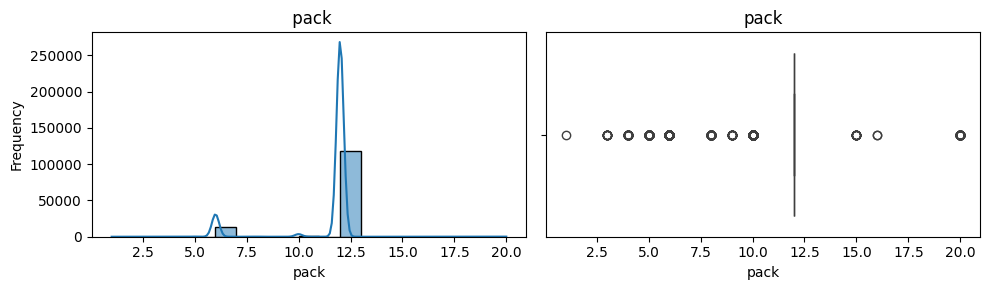

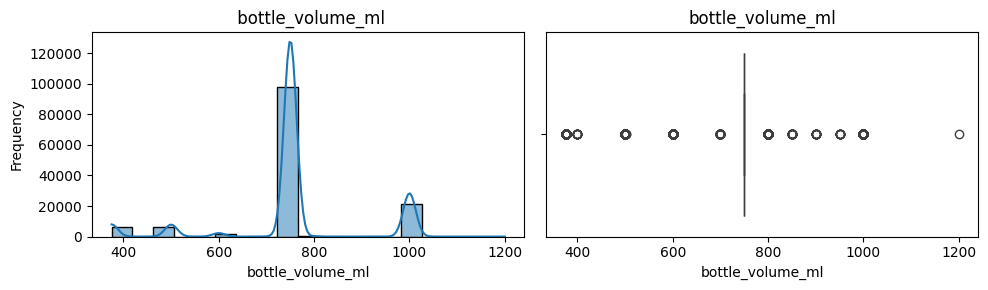

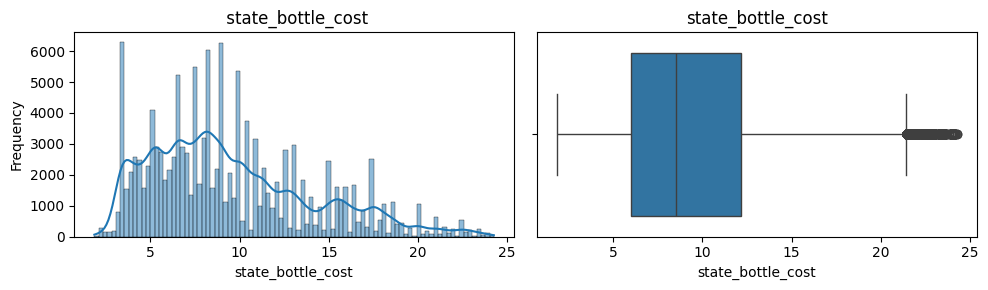

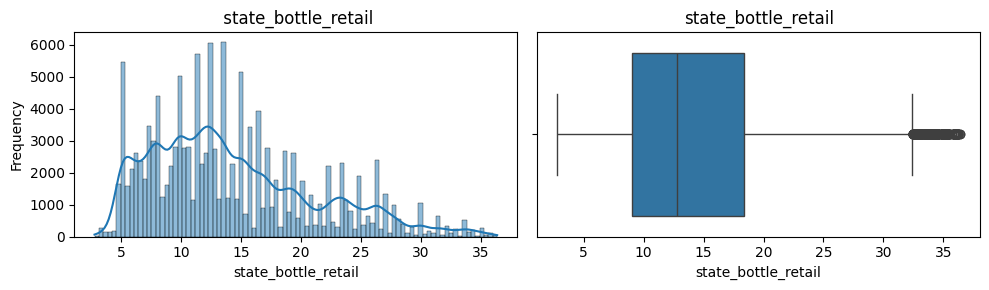

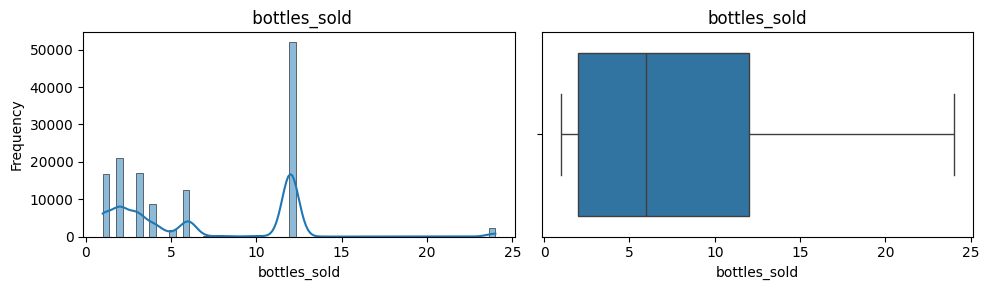

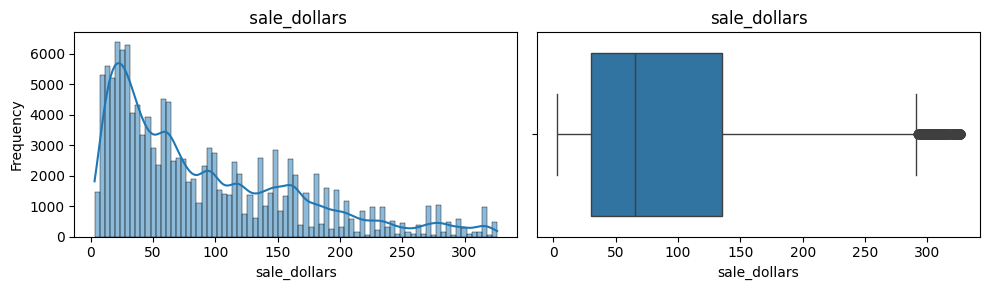

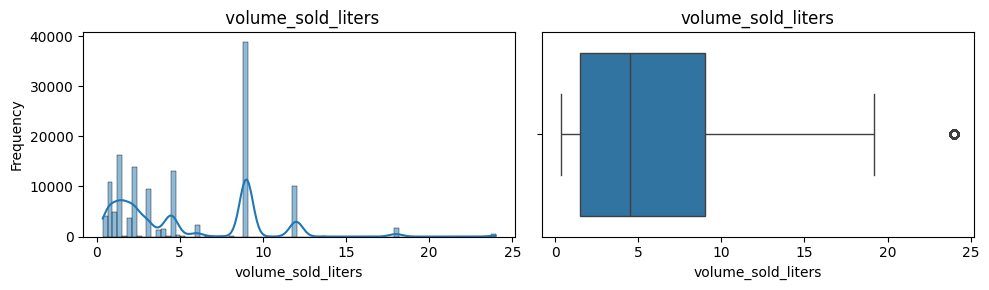

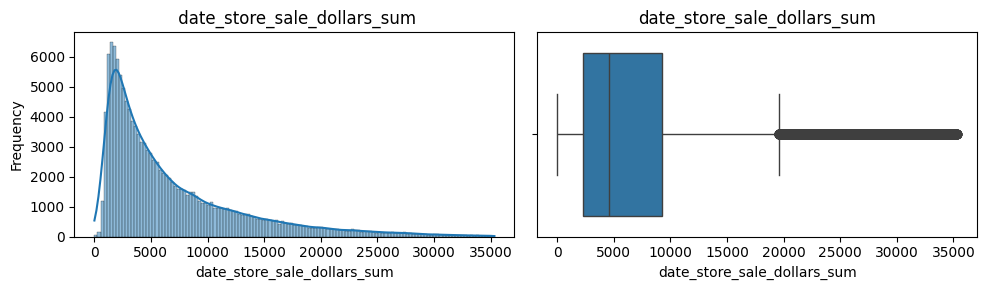

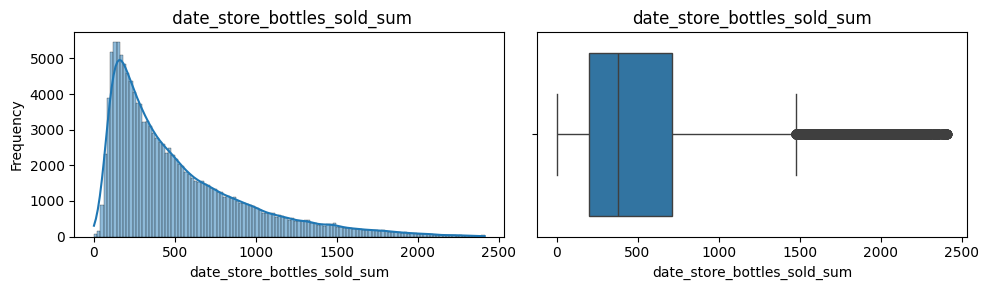

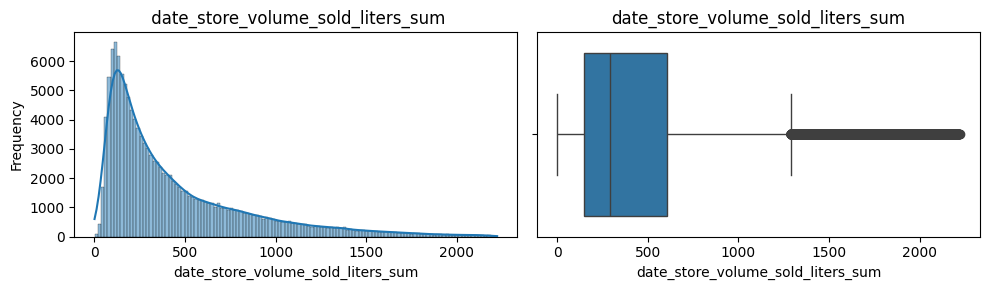

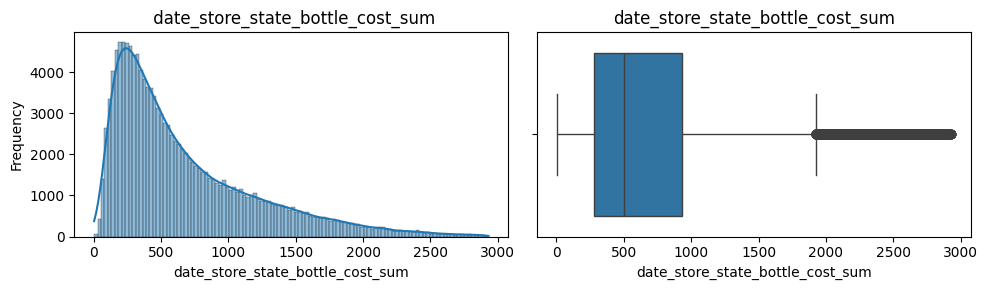

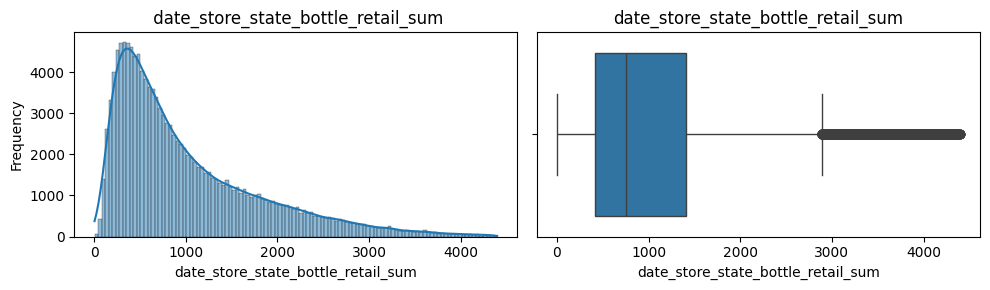

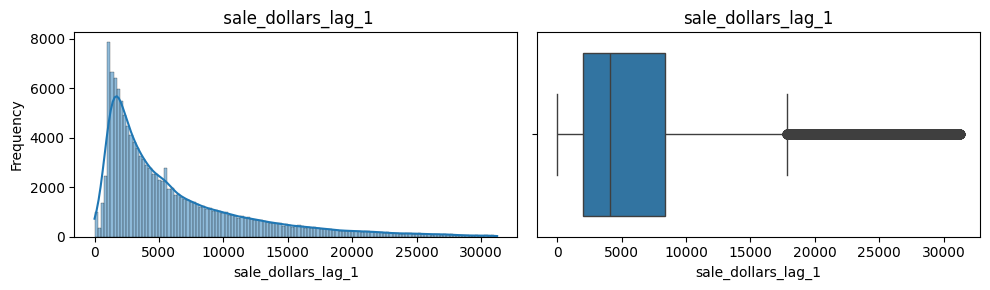

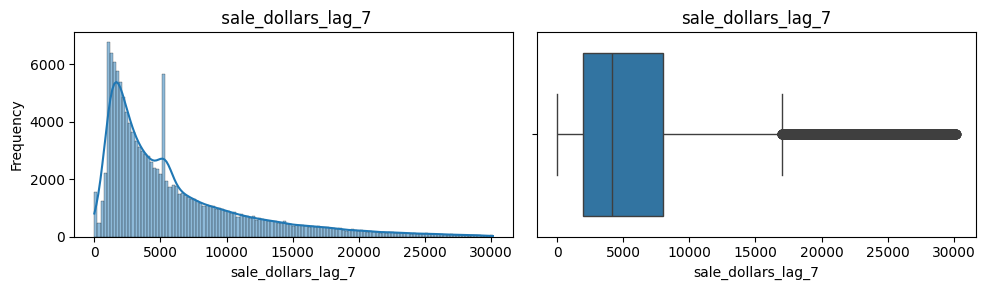

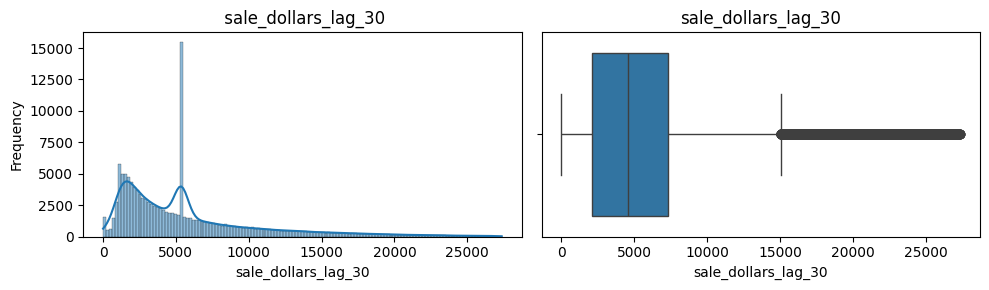

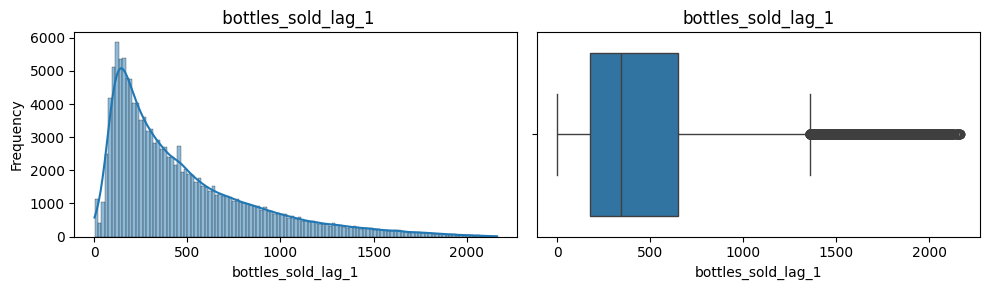

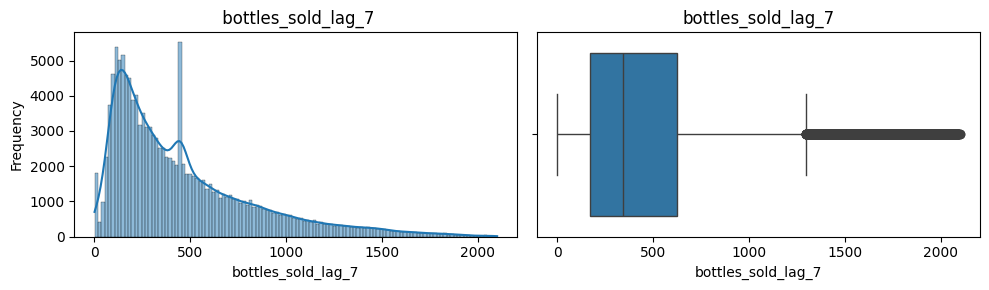

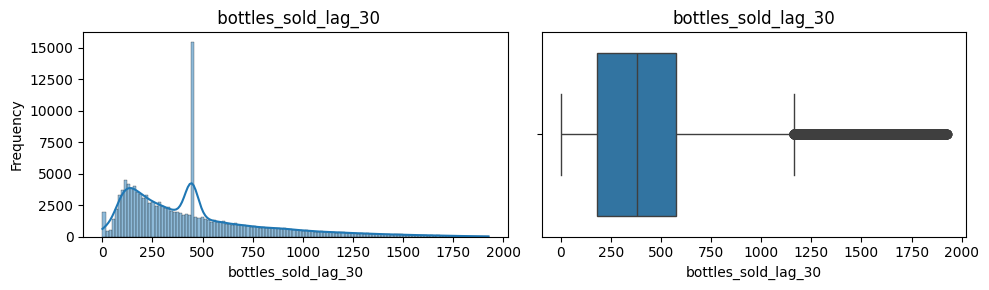

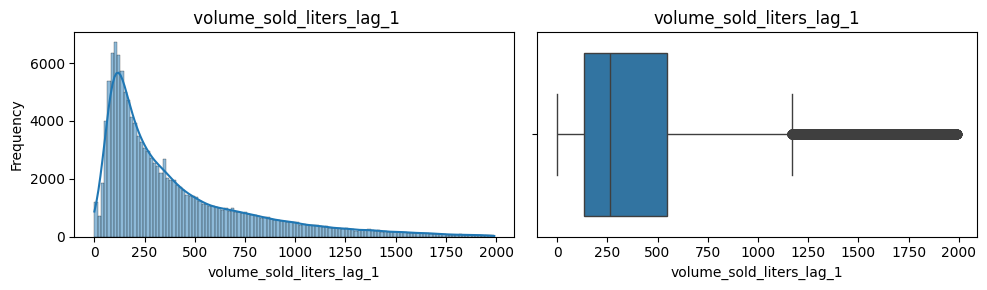

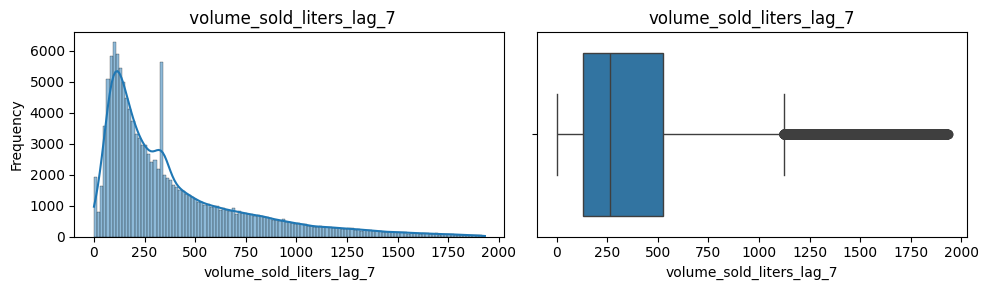

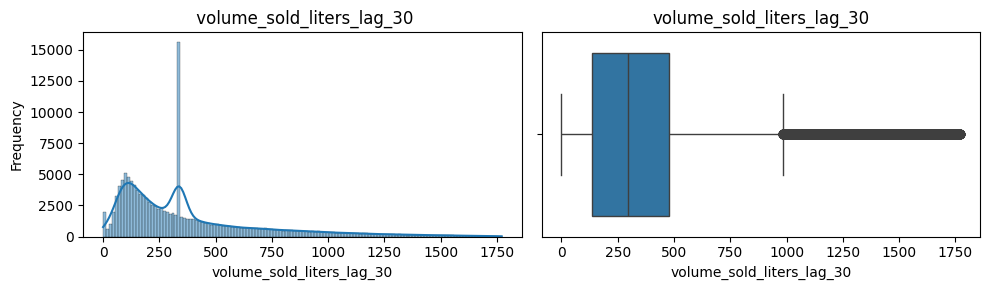

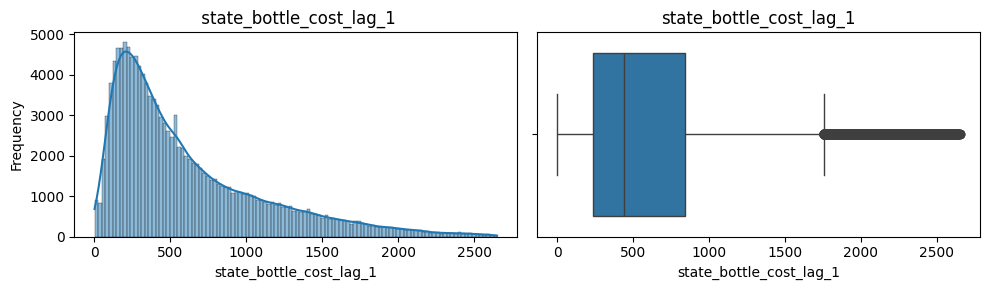

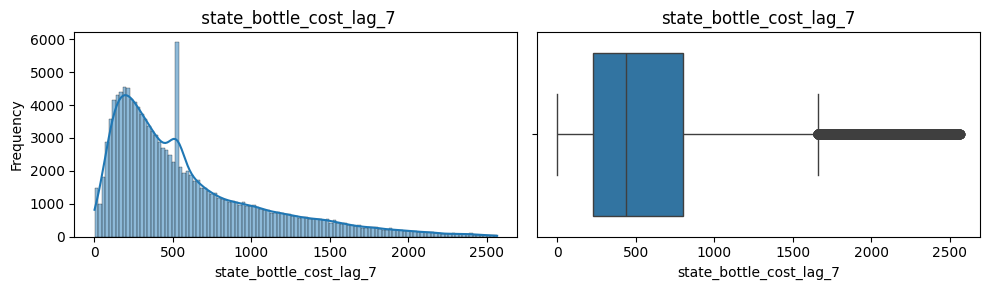

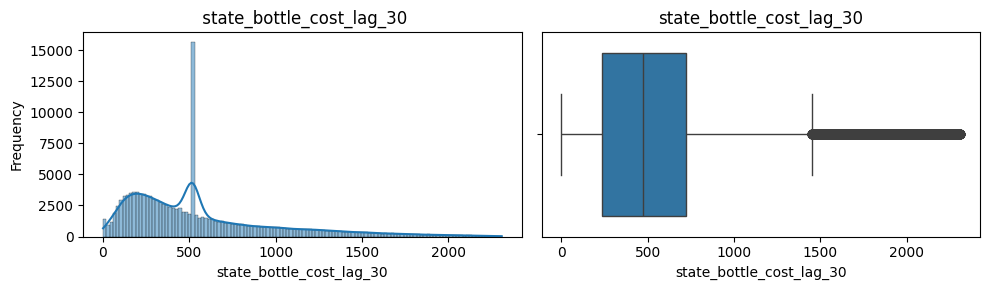

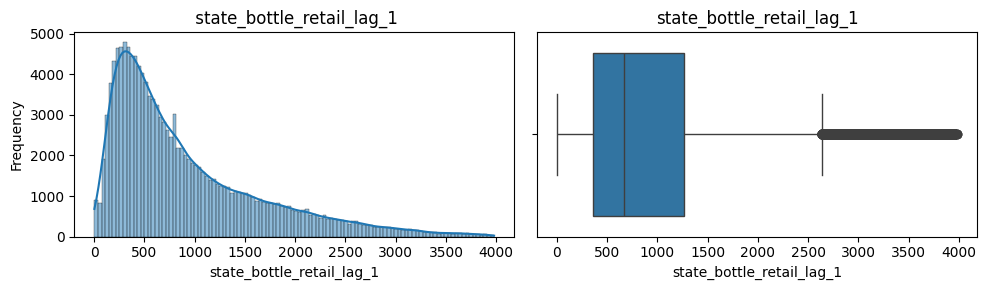

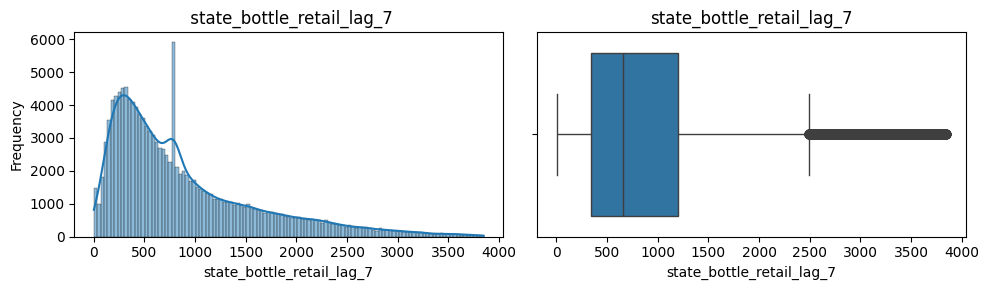

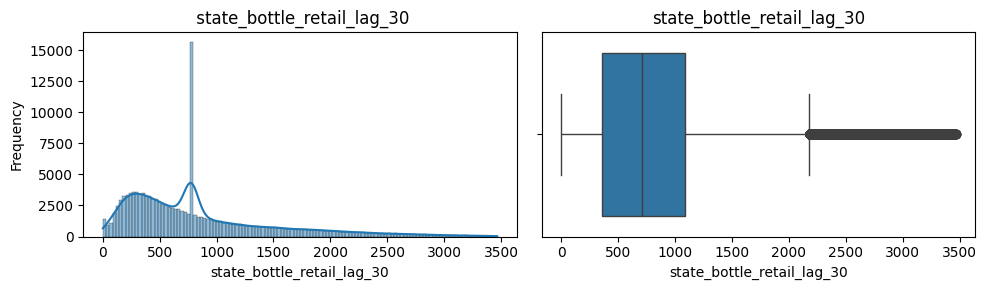

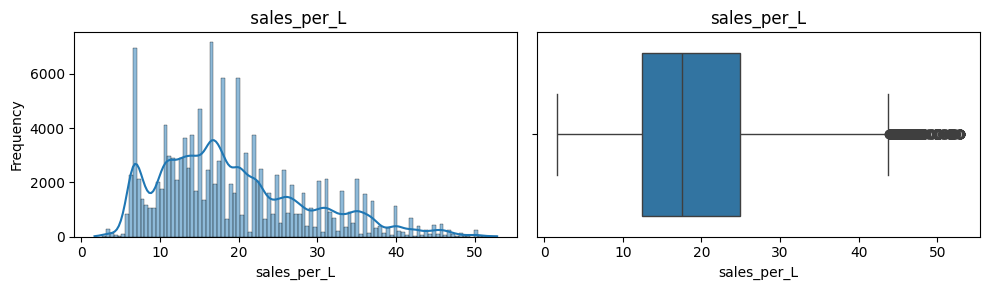

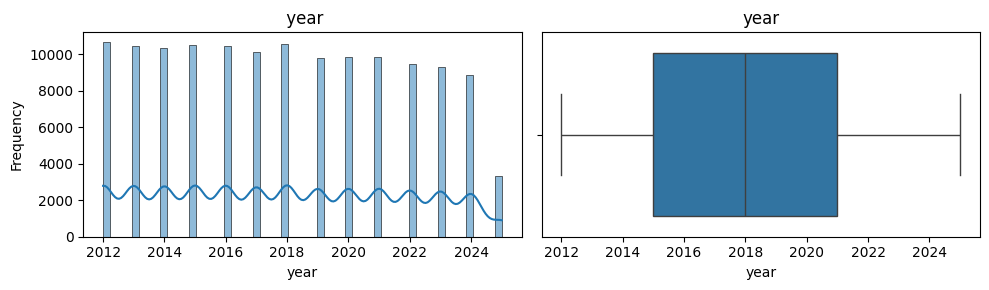

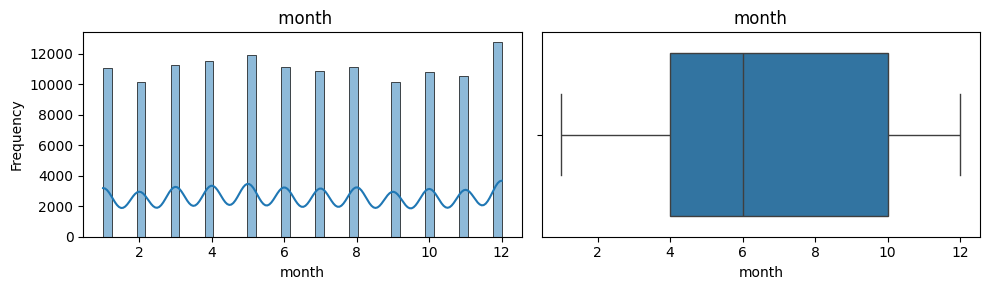

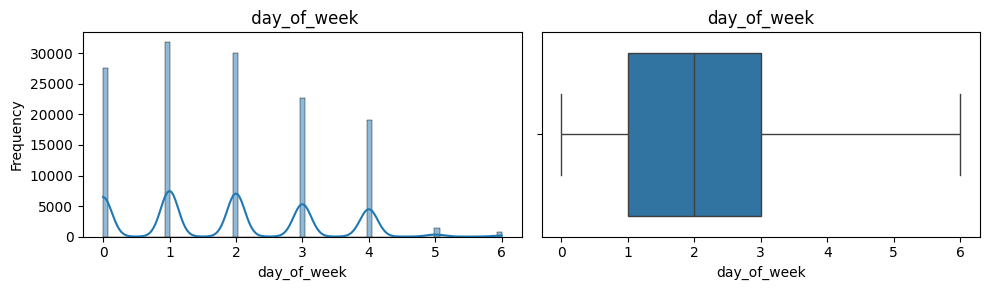

In [44]:
#量的変数の分布可視化
numerical_cols = sample_df.select_dtypes(include=['number']).columns

Q1 = sample_df[numerical_cols].quantile(0.25)
Q3 = sample_df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

sample_df_cleaned = sample_df.copy()
for col in numerical_cols:
  sample_df_cleaned = sample_df_cleaned[(sample_df_cleaned[col] >= lower_bound[col]) & (sample_df_cleaned[col] <= upper_bound[col])]

for col in numerical_cols:
  fig, axes = plt.subplots(1, 2, figsize=(10, 3))
  sns.histplot(data=sample_df_cleaned, x=col, ax=axes[0], kde=True)
  axes[0].set_title(f' {col}')
  axes[0].set_xlabel(col)
  axes[0].set_ylabel('Frequency')

  sns.boxplot(data=sample_df_cleaned, x=col, ax=axes[1])
  axes[1].set_title(f'{col}')
  axes[1].set_xlabel(col)
  axes[1].set_ylabel('')

  plt.tight_layout()
  plt.show()

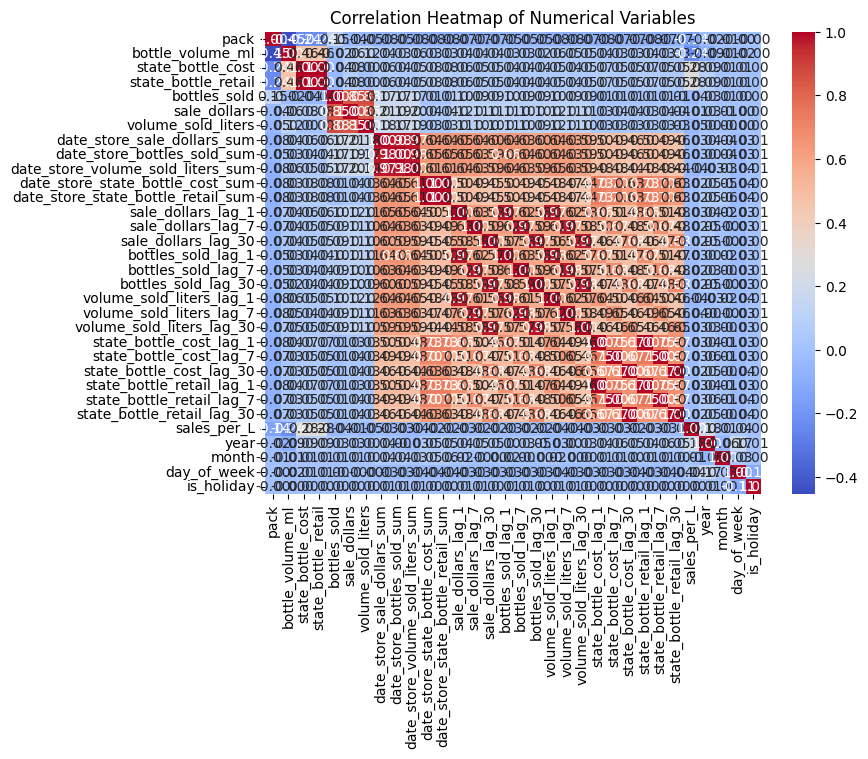

In [45]:
#各変数間の相関
plt.figure(figsize=(8, 6))
sns.heatmap(sample_df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

✅insight：
- volume_sold_littersとbottles_sold高相関な理由：本数が売れるほど、売り上げた総容量も大きくなる
- bottles_sold、volume_sold_littersとsaledollars高相関な理由:総容量が売り上げに貢献している


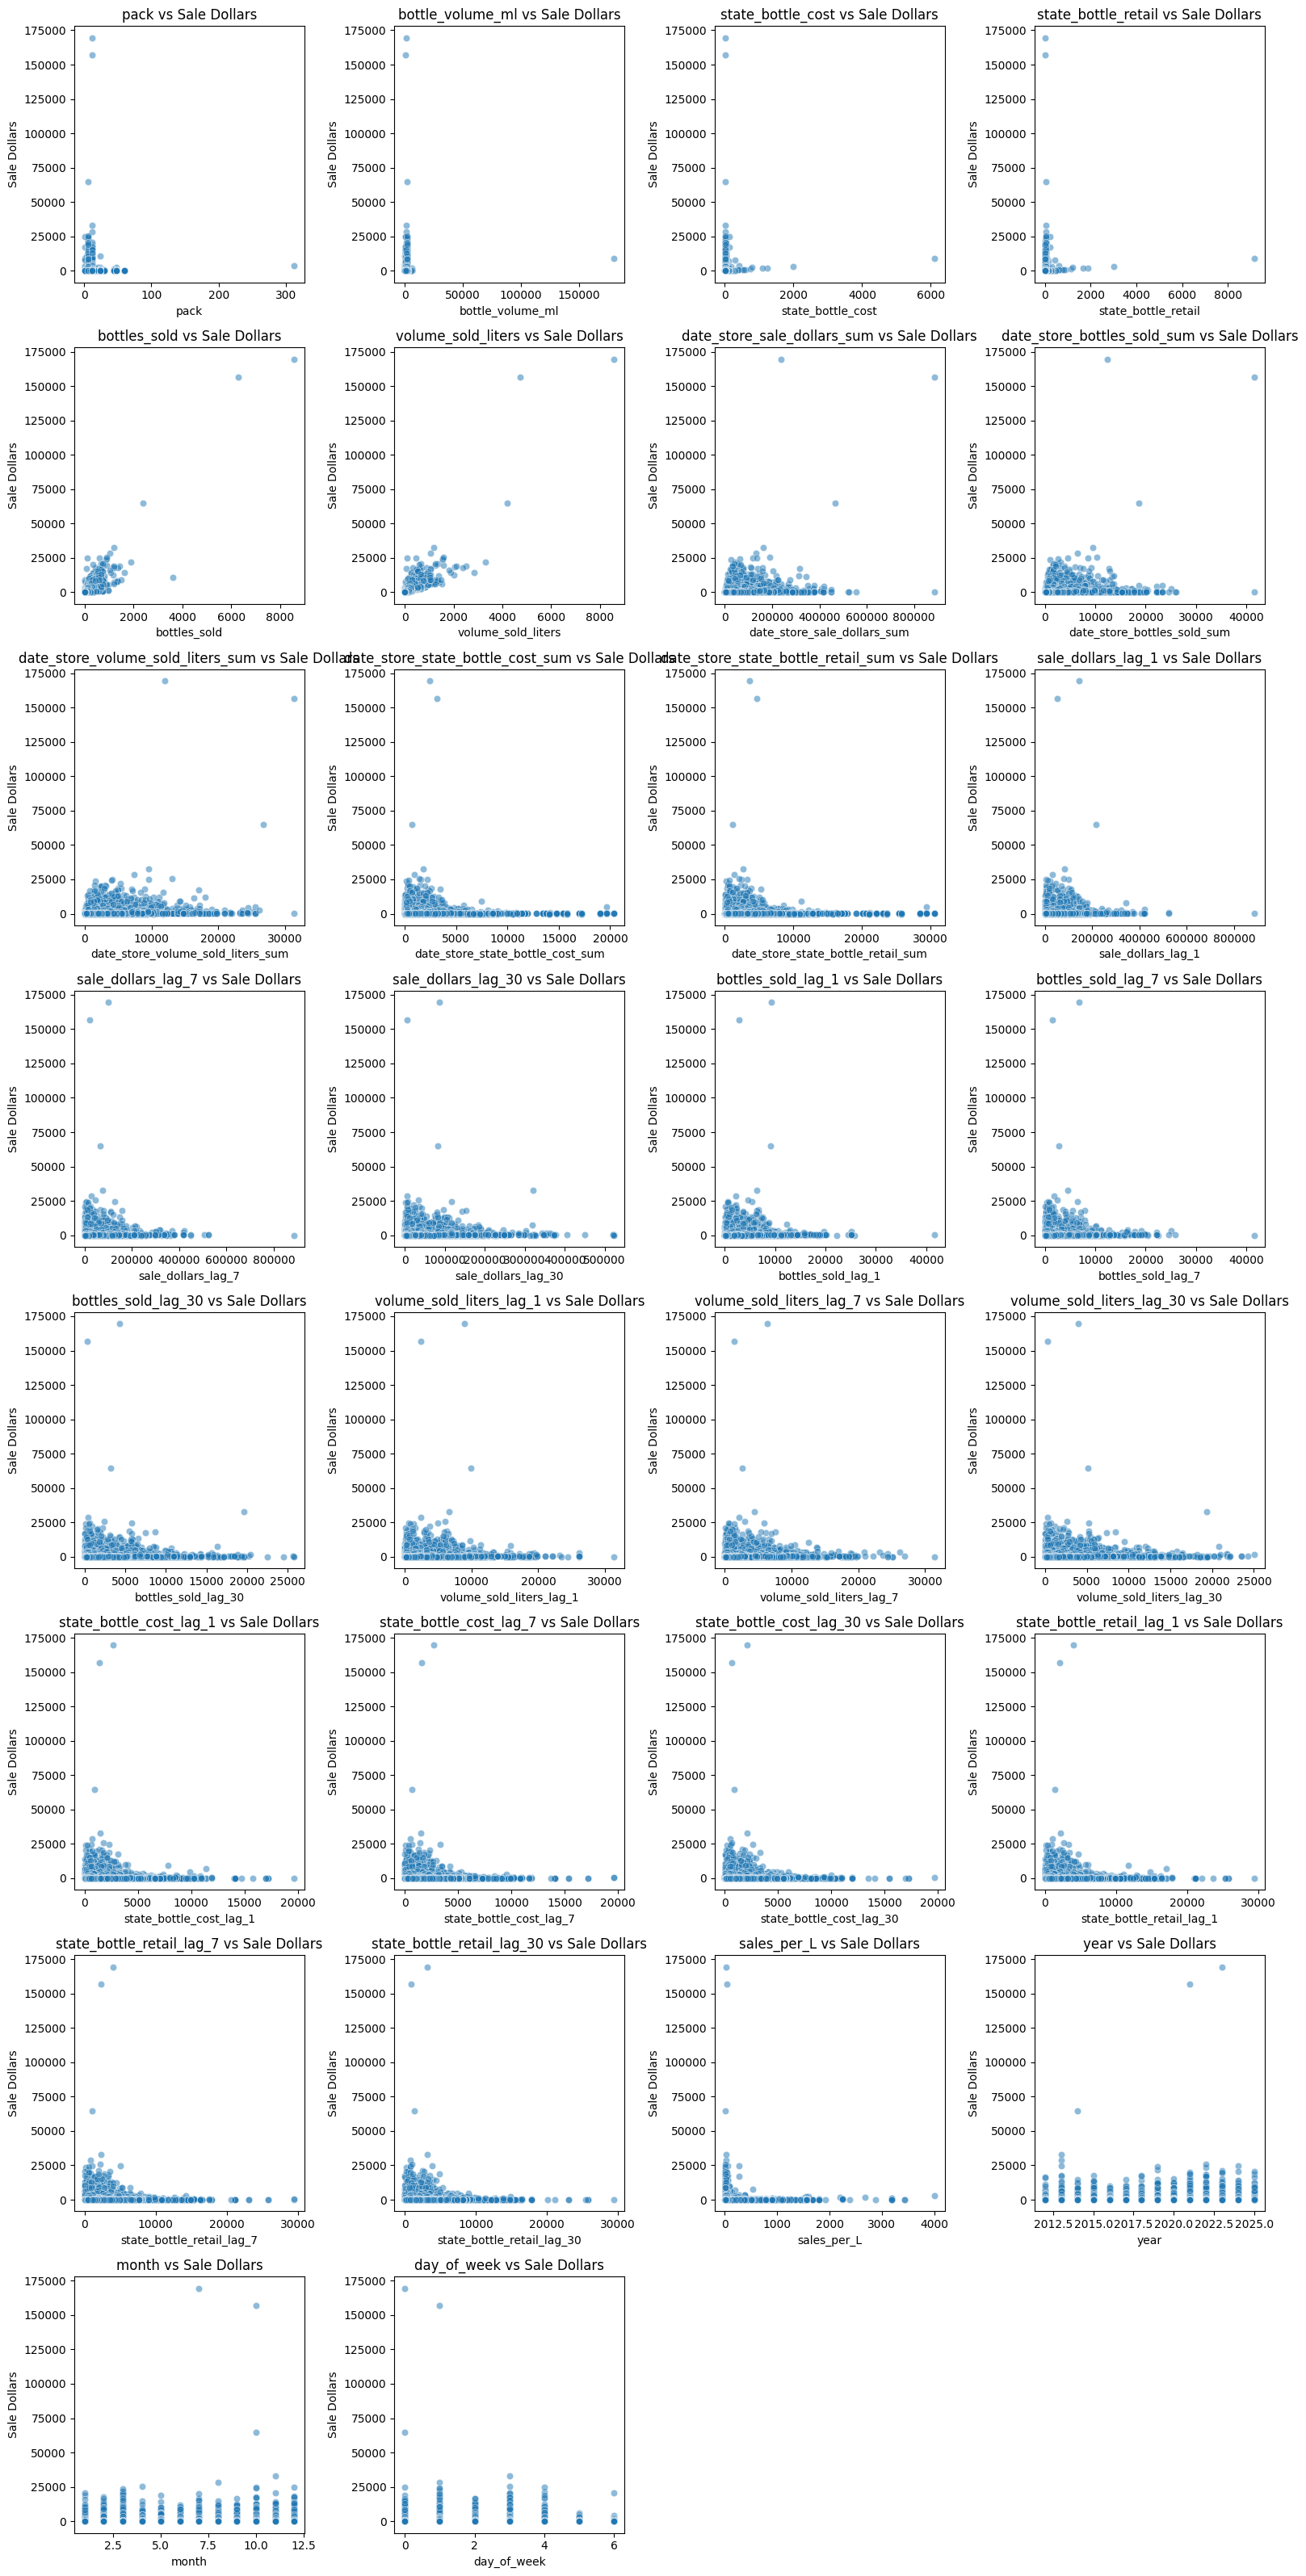

In [46]:
#量的変数と'sale_dollars'の関係性可視化
numeric_cols_excluding_target = sample_df.select_dtypes(include=['number']).columns.tolist()
numeric_cols_excluding_target.remove('sale_dollars')

n_cols = 4
n_rows = (len(numeric_cols_excluding_target) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols_excluding_target):
    sns.scatterplot(x=col, y='sale_dollars', data=sample_df, ax=axes[i], alpha=0.5)
    axes[i].set_title(f'{col} vs Sale Dollars')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Sale Dollars')

# 残りの空のサブプロットを非表示にする
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [47]:
#質的変数の分布
categorical_cols = ['store_number',"county","category","vendor_number",]
value_counts_dict = {}
for col in categorical_cols:
    value_counts_dict[col] = df_redundant_del[col].value_counts().compute().sort_values(ascending=False)
    print(value_counts_dict[col])

store_number
3773     298560
2633     258784
4829     227666
2190     190891
2572     167891
          ...  
9934          2
10572         1
9938          1
9017          1
9937          1
Name: count, Length: 3241, dtype: int64[pyarrow]
county
POLK          5917624
LINN          2795200
SCOTT         1898938
BLACK HAWK    1773782
JOHNSON       1555043
               ...   
WAYNE           25906
DAVIS           21337
RINGGOLD        20710
FREMONT         12611
EL PASO             2
Name: count, Length: 100, dtype: int64[pyarrow]
category
1031100    3420851
1012100    3050255
1011200    2095175
1031200    1566598
1081600    1548157
            ...   
101220           6
1089290          1
1011000          1
1082300          1
1900000          1
Name: count, Length: 114, dtype: int64
vendor_number
260    5192462
421    3178201
65     2864268
434    2653037
370    1839314
        ...   
436          1
853          1
714          1
622          1
855          1
Name: count, Length: 513, dty

✅insight：
- 各カテゴリ変数のカテゴリ数が多すぎるため、one-Hotエンコーディングには適さない。下位〇〇件を"other"とすると、個々の意味が失われてしまう可能性があるため、ターゲットエンコーディングを採用する(中央値で置換)

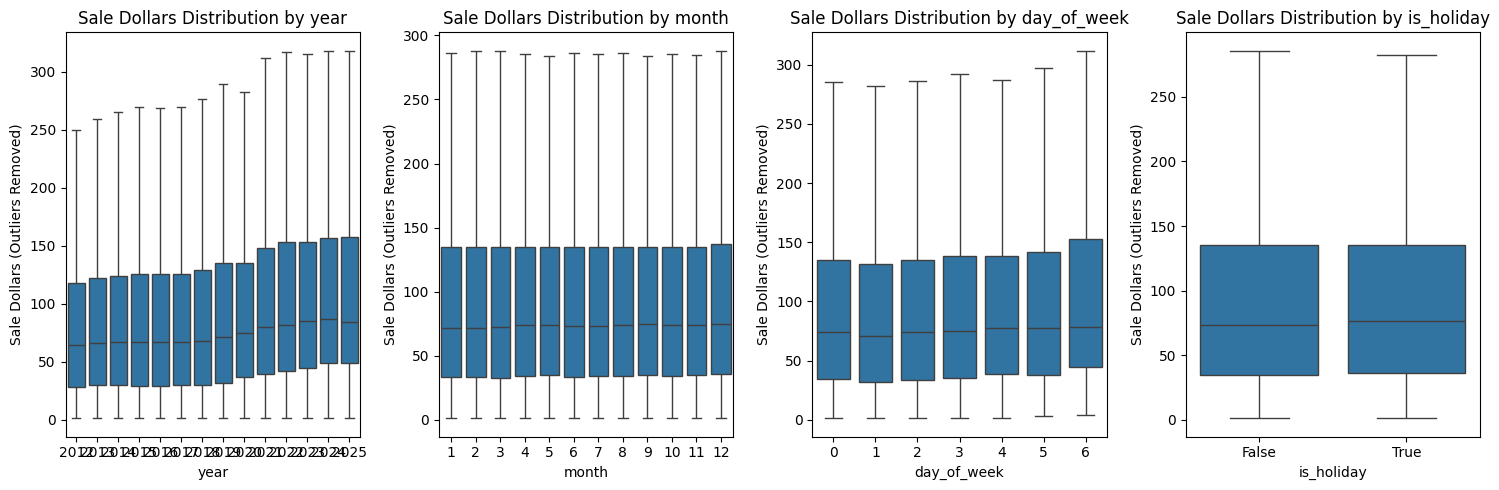

In [50]:
#質的変数(日付関連)と'sale_dollars'の関係性可視化
cols_to_visualize = ['year', 'month', 'day_of_week', 'is_holiday']
fig, axes = plt.subplots(1, len(cols_to_visualize), figsize=(15, 5))

for i, col in enumerate(cols_to_visualize):
    Q1 = sample_df['sale_dollars'].quantile(0.25)
    Q3 = sample_df['sale_dollars'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    trimmed_sale_dollars = sample_df[(sample_df['sale_dollars'] >= lower_bound) & (sample_df['sale_dollars'] <= upper_bound)]
    sns.boxplot(x=col, y='sale_dollars', data=trimmed_sale_dollars, ax=axes[i], showfliers=False)
    axes[i].set_title(f'Sale Dollars Distribution by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Sale Dollars (Outliers Removed)')

plt.tight_layout()
plt.show()

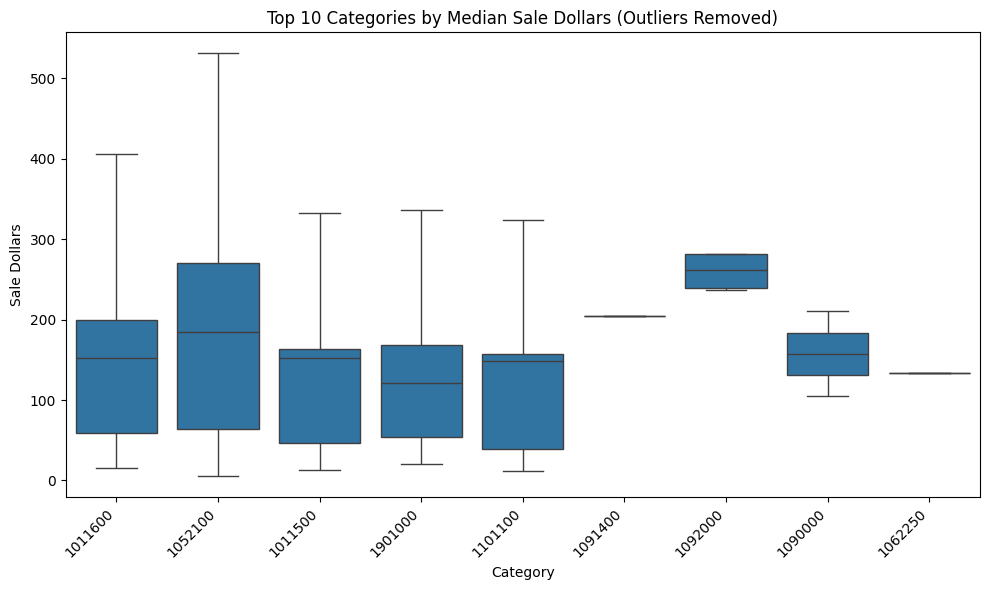

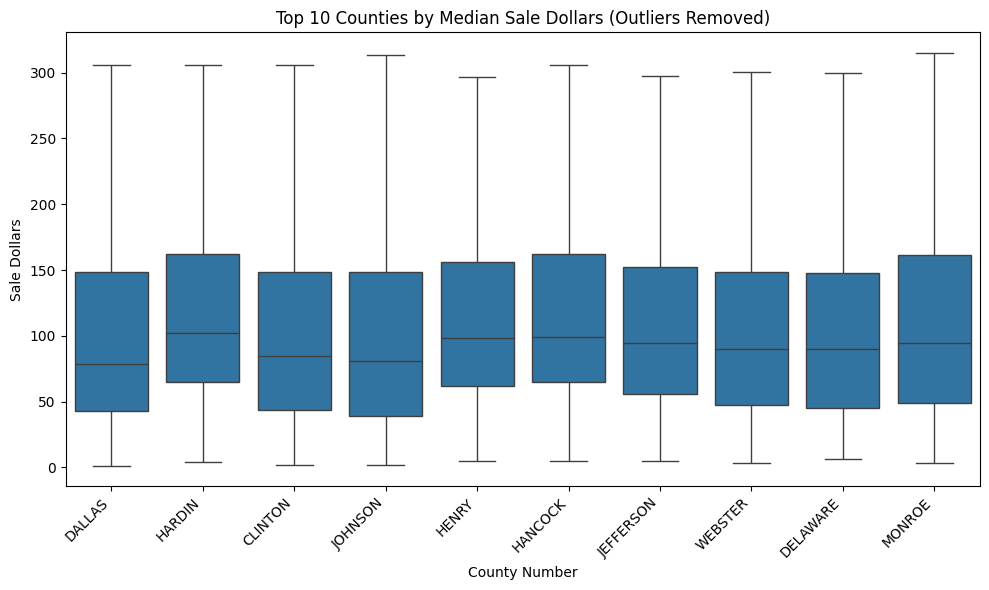

In [49]:
#質的変数(カテゴリ変数)と'sale_dollars'の関係性可視化
top_10_categories = sample_df.groupby('category')['sale_dollars'].median().nlargest(10).index
sample_df_top_10_category = sample_df[sample_df['category'].isin(top_10_categories)].copy()

Q1_cat = sample_df_top_10_category['sale_dollars'].quantile(0.25)
Q3_cat = sample_df_top_10_category['sale_dollars'].quantile(0.75)
IQR_cat = Q3_cat - Q1_cat
lower_bound_cat = Q1_cat - 1.5 * IQR_cat
upper_bound_cat = Q3_cat + 1.5 * IQR_cat
trimmed_sale_dollars_category = sample_df_top_10_category[(sample_df_top_10_category['sale_dollars'] >= lower_bound_cat) & (sample_df_top_10_category['sale_dollars'] <= upper_bound_cat)]

plt.figure(figsize=(10, 6))
sns.boxplot(x='category', y='sale_dollars', data=trimmed_sale_dollars_category, showfliers=False)
plt.title('Top 10 Categories by Median Sale Dollars (Outliers Removed)')
plt.xlabel('Category')
plt.ylabel('Sale Dollars')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


top_10_counties = sample_df.groupby('county')['sale_dollars'].median().nlargest(10).index

sample_df_top_10_county = sample_df[sample_df['county'].isin(top_10_counties)].copy()

Q1_county = sample_df_top_10_county['sale_dollars'].quantile(0.25)
Q3_county = sample_df_top_10_county['sale_dollars'].quantile(0.75)
IQR_county = Q3_county - Q1_county
lower_bound_county = Q1_county - 1.5 * IQR_county
upper_bound_county = Q3_county + 1.5 * IQR_county
trimmed_sale_dollars_county = sample_df_top_10_county[(sample_df_top_10_county['sale_dollars'] >= lower_bound_county) & (sample_df_top_10_county['sale_dollars'] <= upper_bound_county)]

plt.figure(figsize=(10, 6))
sns.boxplot(x='county', y='sale_dollars', data=trimmed_sale_dollars_county, showfliers=False)
plt.title('Top 10 Counties by Median Sale Dollars (Outliers Removed)')
plt.xlabel('County Number')
plt.ylabel('Sale Dollars')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
df_redundant_del.reset_index(drop=True)[sorted(df_redundant_del.columns)]
df_redundant_del.to_parquet("gs://iowa_liquor_sales_ml/cleaned_data/Feature Eng", write_index=False)

##### モデル作成

###### 学習データとテストデータの作成

In [20]:
gcs_path = "gs://iowa_liquor_sales_ml/cleaned_data/Feature Eng/*.parquet"
all_data = dd.read_parquet(
    gcs_path,
    storage_options={"token": "cloud"},
    engine="pyarrow"
)

In [21]:
all_data.dtypes

,0
date,datetime64[ns]
store_number,string[pyarrow]
county,string[pyarrow]
category,string[pyarrow]
vendor_number,string[pyarrow]
item_number,string[pyarrow]
pack,int64
bottle_volume_ml,int64
state_bottle_cost,float64
state_bottle_retail,float64


In [26]:
#目的変数と説明変数の定義
target = "sale_dollars"
quantitative_features = [col for col in all_data.columns if col not in [target, 'date']]

# 質的変数の定義
categorical_cols = ['store_number',"county","category","vendor_number","item_number",'year', 'month', 'day_of_week', 'is_holiday']
#量的変数の定義
numeric_cols = [col for col in quantitative_features if col not in categorical_cols]
print("質的変数のカラム名:", categorical_cols)
print("量的変数のカラム名:", numeric_cols)

#重回帰モデル用データをサンプリング
sample_fraction = 0.01
df_sample = all_data.sample(frac=sample_fraction, random_state=42)
df_sample = df_sample.compute()

質的変数のカラム名: ['store_number', 'county', 'category', 'vendor_number', 'item_number', 'year', 'month', 'day_of_week', 'is_holiday']
量的変数のカラム名: ['pack', 'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail', 'bottles_sold', 'volume_sold_liters', 'date_store_sale_dollars_sum', 'date_store_bottles_sold_sum', 'date_store_volume_sold_liters_sum', 'date_store_state_bottle_cost_sum', 'date_store_state_bottle_retail_sum', 'sale_dollars_lag_1', 'sale_dollars_lag_7', 'sale_dollars_lag_30', 'bottles_sold_lag_1', 'bottles_sold_lag_7', 'bottles_sold_lag_30', 'volume_sold_liters_lag_1', 'volume_sold_liters_lag_7', 'volume_sold_liters_lag_30', 'state_bottle_cost_lag_1', 'state_bottle_cost_lag_7', 'state_bottle_cost_lag_30', 'state_bottle_retail_lag_1', 'state_bottle_retail_lag_7', 'state_bottle_retail_lag_30', 'sales_per_L']


✅insight：各カラムについてエンコーディング方法を定義
- store_number：ターゲットエンコーディング
- county_number：ターゲットエンコーディング
- category：ターゲットエンコーディング
- vendor_number：ターゲットエンコーディング
- item_number：ターゲットエンコーディング
- year：そのまま使用
- month： One-Hotエンコーディング
- day_of_week： One-Hotエンコーディング
- is_holiday：そのまま使用

In [32]:
#ターゲットエンコーディング
target_encoding_cols = ['store_number', 'county', 'category', 'vendor_number',"item_number"]
df_sample_te = df_sample.copy()
global_median = df_sample_te[target].median()

for col in target_encoding_cols:
    target_median = df_sample_te.groupby(col)[target].median()
    df_sample_te[col + "_te"] = df_sample_te[col].map(target_median)
    df_sample_te[col + "_te"] = df_sample_te[col].map(target_median).fillna(global_median)
    df_sample_te = df_sample_te.drop(columns=[col])

quantitative_features_te = [col for col in quantitative_features if col not in target_encoding_cols]
quantitative_features_te += [col + "_te" for col in target_encoding_cols]

# 時系列リークを考慮したスプリット（例：80%を学習、20%をテストに）
df_sample_te = df_sample_te.sort_values("date")
X = df_sample_te[quantitative_features_te]
y = df_sample_te[target]

n_total = len(df_sample_te)
n_train = int(n_total * 0.8)
train_idx_te = list(range(n_train))
test_idx_te = list(range(n_train, n_total))

X_train_te = X.iloc[train_idx_te]
X_test_te = X.iloc[test_idx_te]
y_train_te = y.iloc[train_idx_te]
y_test_te = y.iloc[test_idx_te]

In [27]:
one_hot_cols = ['month', 'day_of_week']

In [18]:
#未使用

# train_idx, test_idx = train_test_split(range(len(df_sample)), test_size=0.2, random_state=42)
# X_train = df_sample.iloc[train_idx][quantitative_features]
# y_train = df_sample.iloc[train_idx][target]
# X_test = df_sample.iloc[test_idx][quantitative_features]
# y_test = df_sample.iloc[test_idx][target]

# #加工用のx_trainとx_testを用意
# X_train_process = X_train.copy()
# X_test_process = X_test.copy()
# y_train_process = y_train.copy()

###### エンコーディング

###### 対数変換とスケーリング

In [ ]:
#未使用

# #対数変換
# y_test_te_log = np.log1p(y_train_te)

# log_cols= ['pack', 'bottle_volume_ml', 'state_bottle_cost', 'state_bottle_retail', 'bottles_sold', 'volume_sold_liters','sales_per_L']
# skewed = X_train_te[log_cols].apply(lambda x: skew(x.dropna()))
# skewed_feats = skewed[skewed > 0.75].index

# X_train_te_log[skewed_feats] = np.log1p(X_train_te[skewed_feats])
# X_test_te_log[skewed_feats] = np.log1p(X_test_te[skewed_feats])

# #スケーリング
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train[numeric_cols])
# X_test_scaled = scaler.transform(X_test[numeric_cols])

In [33]:
# 線形回帰モデルの学習
model = LinearRegression()
model.fit(X_train_te, y_train_te)

LinearRegression()

In [34]:
# 予測
y_pred = model.predict(X_test_te)

# モデルの評価
mse = mean_squared_error(y_test_te, y_pred)
r2 = r2_score(y_test_te, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

#coef評価


Mean Squared Error: 85904.83629224336
R-squared: 0.696990878375844
